## Vision Transformers

We will begin with implementing a Vision Transformer on the MNIST dataset, then you will do this for CIFAR10 (same as CNN lecture).
Being that we didn't get a chance to implement the attention mechanism or transformers yesterday, we are going to do it now.

I will provide you will the base model code below, in which you will be required to write some code. We will be using Multi-Head Self-Attention with no masking here.

The purpose of this is to not obtain remarkable performance. We want to:

1. Have you implement MHSA (this is generic - works for text, images, etc)
2. Understand how transformers can be used for images - treating patches as "tokens"

In [ ]:
# Import libraries
import pkbar
import numpy as np
import einops
from einops.layers.torch import Rearrange

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
else:
  print('cpu')

cuda
NVIDIA A40


In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])])

mnist_classes = ['0', '1', '2', '3', '4',
                   '5', '6', '7', '8', '9']

full_train_dataset = datasets.MNIST(root="./",
                                   train=True, # the training set of the MNIST dataset is being requested.
                                   transform=transform, # transform=transform applies the transformation defined earlier
                                   download=True) # tells the library to download the dataset if it's not available at the specified root

test_dataset = datasets.MNIST(root='./', train=False, transform=transform, download=True)


# Split train into train/val
train_size = int(0.9 * len(full_train_dataset))  # 45,000
val_size = len(full_train_dataset) - train_size  # 5,000
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size]) # Note we use random_split here - a convenient way to do what we did by hand above

# DataLoaders
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
print("Training size: ", len(train_dataset))
print("Validation size: ", len(val_dataset))
print("Test size: ", len(test_dataset))

Training size:  54000
Validation size:  6000
Test size:  10000


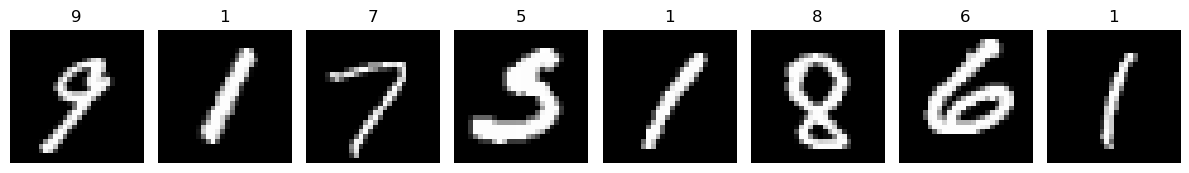

In [ ]:
import matplotlib.pyplot as plt

def imshow(img, mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]):
    """Unnormalize and show an image tensor."""
    img = img.numpy().transpose((1, 2, 0))  # CHW -> HWC
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)

def show_samples_mnist(loader, classes, n=8):
    """Display a grid of n images from a DataLoader with their labels."""
    images, labels = next(iter(loader))
    plt.figure(figsize=(12, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        imshow(images[i])
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
show_samples(train_dl, mnist_classes, n=8)

### The Vision Transformer Class

We are going to walk through this step by step and create the individual components.
First, we need the **Feed Forward Neural Network**. This network should contain:

1. A Linear Layer - input=embed_dim, output = embed_dim * mlp_scale
2. GELU Activation Funciton
3. A Linear Layer - input=embed_dim * mlp_scale , output=embed_dim
4. Dropout

In [ ]:
class FF(nn.Module):
    def __init__(self,embed_dim, mlp_scale : int = 2, drop_rate: float = 0.0):
        super().__init__()


    def forward(self,x):
        return

Now lets make our Multi-Head Self-Attention Class.

I have provided you with detailed instructions through comments. If you have issues let me know.
Make sure you read the comments - this is all about shapes.
We do not do explicit concatenation, but rather implicit concatenation through reshaping to perform the Multi-Head parts.

In [ ]:
class MHSA(nn.Module):
    def __init__(self, embed_dim, num_heads, seq_len=250, dropout=0.2,device='cuda'):
        super().__init__()

        assert embed_dim % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.seq_length = seq_len
        self.head_dim = embed_dim // num_heads
        self.d_k = self.head_dim ** 0.5
        self.device = device
        # Create the projections for Q,K,V
        self.k_proj =
        self.q_proj =
        self.v_proj =
        self.dropout = nn.Dropout(dropout)


    def forward(self, x,attn_mask=None,key_padding_mask=None,need_weights=False):
        batch_size, seq_len, embed_dim = x.shape

        # Project input x to queries, keys, and values
        q =
        k =
        v =

        # We want multi-head attention - typically this is done through reshaping our output
        # This is implicit concatenation - equivalent
        # We will use the tensor.view() operation
        # Hint: We want our Q,K,V matrices to be shaped like (batch,seq_len,num_heads,head_dim)
        k =
        v =
        q =

        # Transpose to align axis for computation of attention scores per head
        # (batch,seq_len,num_heads,head_dim) -> (batch,num_heads,seq_len,head_dim)
        # Hint: We want to use a transpose over dimensions (1,2) for all three
        k =
        q =
        v =

        # Compute the attention scores with matrix operations - this is the argument of the softmax QK^T / sqrt(d_k)
        # again we need to be careful with the dimensions of K after we transpose
        # K is of shape (batch, num_heads, seq_len, head_dim)
        # Q is of shape (batch, num_heads, seq_len, head_dim)
        # To compute Q @ K^T, we need to transpose the last two dimensions of K so that:
        # K.transpose(2, 3) gives shape (batch, num_heads, head_dim, seq_len)
        # Resulting attn_scores shape: (batch, num_heads, seq_len, seq_len)
        # Each attention head now contains a full pairwise similarity matrix between all tokens
        # We also need to divide by self.d_k for normalization constant!
        attn_scores =

        # This will always be None for our models
        # I am strategically leaving it here for you in case you want to use Masked MHSA
        if attn_mask is not None:
            attn_scores.masked_fill_(attn_mask,-torch.inf)

        # This will also always be None for our models
        # I am strategically leaving it here for you in case you do something with padded inputs (i.e. [SOS,token1,token2, ..., tokenN,EOS,pad,pad,pad,pad])
        if key_padding_mask is not None:
            key_padding_mask = key_padding_mask[:, None, None, :]
            attn_scores.masked_fill_(key_padding_mask,-torch.inf)

        # Compute the softmax over our attention scores. This should be over the last dimension - dim=-1
        # Use nn.functional to do this - we imported it as F
        attn_scores =

        # Apply dropout
        attn_scores = self.dropout(attn_scores)

        # Now we have our attention weights in the form softmax(QK^T / sqrt(d_k))
        # Your next task is to apply these attention weights to the Value matrix V.
        # This means performing a batched matrix multiplication between attn_scores and v.
        # Hint: This is softmax(QK^T / sqrt(d_k)) @ V
        # attn_scores shape: (batch, num_heads, seq_len, seq_len)
        # v shape:           (batch, num_heads, seq_len, head_dim)
        # The result should be of shape: (batch, num_heads, seq_len, head_dim)
        # Fill in this line with the correct matrix multiplication
        attn_output = attn_scores @ v

        # Now you need to rearrange the output so that the num_heads dimension is moved after the seq_len.
        # attn_output is currently shaped: (batch, num_heads, seq_len, head_dim)
        # You want to transpose it to: (batch, seq_len, num_heads, head_dim)
        # This will prepare it to be reshaped into the original embedding dimension.
        # Hint: We want to use a transpose over dimensions (1,2)
        # Fill in this line with the correct matrix multiplication
        attn_output =

        # Finally, flatten the last two dimensions (num_heads and head_dim) back into a single embedding dimension.
        # The final output should be of shape: (batch, seq_len, embed_dim), where embed_dim = num_heads * head_dim
        # I'll give you this one as we need a contiguous call
        attn_output = attn_output.contiguous().view(batch_size,seq_len,embed_dim)

        if need_weights:
            return attn_output,attn_scores
        else:
            return attn_output,None

Now lets create our Transformer Encoder Block

Again I am going to walk you through this with comments.

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self,embed_dim,num_heads, mlp_scale : int = 2,drop_rate: float = 0.2, device='cuda'):
        super().__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.device = device
        self.mlp_scale = mlp_scale
        self.drop_rate = drop_rate
        # We need our first layernorm
        # Hint: nn.LayerNorm() - this will expect tensors with dim=embed_dim
        self.LN1 =
        # Each EncoderBlock will need the attention mechanism we created above
        # it expects (embed_dim=, num_heads=, seq_len=, dropout=,device=)
        # Hint: Look at what we have stored in self. above!
        self.attn =
        # We are going to use an (optional linear projection after the attention - I will do this for you)
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=False)
        # We need our second layernorm - same as above
        self.LN2 =
        # We need our feed forward network that we created above
        # it expects (embed_dim= , mlp_scale=, drop_rate=)
        # Hint: Look at what we have stored in self. above!
        self.FF =


    # We will not use this function
    # This dnymically creates the mask for masked attention
    # There are other (perhaps better) ways to do it through a registering a buffer
    # Leaving it here for you as well
    def generate_mask(self,seq_len):
        return torch.triu(torch.ones((seq_len, seq_len), device=self.device, dtype=torch.bool), diagonal=1)

    def forward(self, x,padding_mask=None,need_weights=False):
        B,N_t,t_dim = x.shape
        # We are going to deploy a pre norm strategy
        # You need to use your first layernorm self.LN1 here to produce x_norm
        x_norm =

        # We pass this to our attention block
        # the output of our this block should be attn,attn_weights
        # Recall that I have left some optional arguments from before, specifcally key_padding_mask and need_weights
        # Set both of these to False explicicty
        attn,attn_weights =

        attn = self.c_proj(attn) # Optional projection layer - done for you

        # Now we need to operform the addition and residual connections
        # Lets first do the addition
        # We want to add our attn output to x
        # Hint: x = x + ____
        x =
        # Now lets do the residual connection - we are going to do this in parts
        # First lets calculate the residual part coming from the FF network.
        # We also want to apply our post norm (LN2) to the input to this network
        # Something like FF(LN2(x))
        res =
        # Now add the residual part back to x
        # Hint: x = x + ___
        x =
        return x

Now lets create our ViT Class

I am going to fully define this for you just for simplicity.

Things to take note of:

1. The init() call - what different operations do we need?
2. The forward() call - try and trace these order of operations. Bring up a picture of a transformer encoder and try to trace the flow!

In [ ]:
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, embed_dim, num_classes=10,
                 attn_heads=[2, 4, 2], mlp_scale: int = 2, drop_rates=[0.0, 0.0, 0.0], device='cuda'):
        super().__init__()

        # Ensure drop_rates and attn_heads lists are consistent
        assert len(drop_rates) == len(attn_heads), "drop_rates and attn_heads must be of same length"
        # Ensure the image dimensions are divisible by the patch size
        assert image_size[1] % patch_size == 0 and image_size[2] % patch_size == 0, \
            'image dimensions must be divisible by the patch size'

        channels = image_size[0]
        # Compute the number of patches by dividing the height and width by patch size
        num_patches = (image_size[1] // patch_size) * (image_size[2] // patch_size)
        # Each patch is flattened into a vector of size (channels * patch_size^2)
        patch_dim = channels * patch_size ** 2
        self.device = device

        # Patch embedding layer:
        # 1. Rearranges the image into a sequence of flattened patches
        # 2. Applies LayerNorm to each patch
        # 3. Projects to the embedding dimension using a Linear layer
        # 4. Applies another LayerNorm
        self.patch_embedding = nn.Sequential(
            Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1=patch_size, p2=patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, embed_dim),
            nn.LayerNorm(embed_dim),
        )

        # Positional embedding to retain spatial information (learned parameter)
        # Shape: (1, num_patches + 1, embed_dim); +1 for the [CLS] token
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

        # Create a list of transformer encoder blocks, each with a different number of attention heads
        # and optional dropout
        layers_ = [
            EncoderBlock(embed_dim, attn_heads[i], mlp_scale, drop_rate=drop_rates[i])
            for i in range(len(attn_heads))
        ]
        self.layers = nn.ModuleList(layers_)

        # Classification head to project the [CLS] token's embedding to logits for each class
        self.mlp_head = nn.Linear(embed_dim, num_classes)

        # Learnable [CLS] token used for classification
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

    def forward(self, x, padding_mask=None):
        batch_size = x.size(0)

        # Convert image into a sequence of embedded patches
        x = self.patch_embedding(x)  # Shape: (B, num_patches, embed_dim)

        # Expand the [CLS] token to match the batch size
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # Shape: (B, 1, embed_dim)

        # Prepend the [CLS] token to the patch embeddings
        x = torch.cat((cls_tokens, x), dim=1)  # Shape: (B, num_patches + 1, embed_dim)

        # Add positional embeddings
        x = x + self.pos_embedding[:, :x.size(1)]  # Shape: (B, num_patches + 1, embed_dim)

        # Pass through the stack of transformer encoder blocks
        for layer in self.layers:
            x = layer(x)

        # Use the [CLS] token's output for classification
        return self.mlp_head(x[:, 0])  # Shape: (B, num_classes)


### Training the model

Lets train our model on the mnist dataset. Take note of the different hyperparameters of the model.

I have left the output of the model below. You should get the same output.

In [ ]:
image_size = train_dataset.__getitem__(0)[0].shape
patch_size = 4 # Patch size - grab patch x patch pixels to form an element in the sequence
embed_dim = 64 # embedding dimension - each patch is projected in a space of dim = embed_dim
mlp_scale = 2 # instead of specifying the MLP dimensions explicitly, scale it based off of embed_dim
drop_rates = [0.0,0.0,0.0] # applied for each encoderblock
attn_heads = [2,2,2] # 3 encoder blocks, each with 2 heads -> embed_dim // attn_heads[i] should = 0
num_classes = len(mnist_classes)
model = ViT(image_size,patch_size,embed_dim,num_classes=num_classes,attn_heads=attn_heads,mlp_scale=mlp_scale,drop_rates=drop_rates,device=device)
t_params = sum(p.numel() for p in model.parameters())
print("Network Parameters: ",t_params)
model.to(device)

Network Parameters:  104810


ViT(
  (patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=16, out_features=64, bias=True)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (layers): ModuleList(
    (0-2): 3 x EncoderBlock(
      (LN1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MHSA(
        (k_proj): Linear(in_features=64, out_features=64, bias=False)
        (q_proj): Linear(in_features=64, out_features=64, bias=False)
        (v_proj): Linear(in_features=64, out_features=64, bias=False)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (c_proj): Linear(in_features=64, out_features=64, bias=False)
      (LN2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (FF): FF(
        (nn): Sequential(
          (0): Linear(in_features=64, out_features=128, bias=True)
          (1): GELU(approximate='none')
          (2

In [ ]:
def train(model, num_epochs, train_dl, valid_dl,lr=0.001,device='cuda',seed=8):
    model.to(device)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        kbar = pkbar.Kbar(target=len(train_dl), epoch=epoch, num_epochs=num_epochs, width=20, always_stateful=False)

        total_correct = 0
        total_loss = 0

        for i, (x_batch, y_batch) in enumerate(train_dl):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            batch_correct = (torch.argmax(pred, dim=1) == y_batch).float().sum()
            total_correct += batch_correct.item()
            total_loss += loss.item() * y_batch.size(0)

            kbar.update(i, values=[("loss", loss.item()), ("acc", batch_correct.item() / y_batch.size(0))])

        loss_hist_train[epoch] = total_loss / len(train_dl.dataset)
        accuracy_hist_train[epoch] = total_correct / len(train_dl.dataset)

        model.eval()
        val_loss = 0
        val_correct = 0
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                val_loss += loss.item() * y_batch.size(0)
                val_correct += (torch.argmax(pred, dim=1) == y_batch).float().sum().item()

        loss_hist_valid[epoch] = val_loss / len(valid_dl.dataset)
        accuracy_hist_valid[epoch] = val_correct / len(valid_dl.dataset)

        kbar.add(1, values=[("val_loss", loss_hist_valid[epoch]), ("val_acc", accuracy_hist_valid[epoch])])

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


num_epochs = 10
hist = train(model, num_epochs, train_dl, valid_dl)

In [ ]:
def plot_loss(hist):
    x_arr = np.arange(len(hist[0])) + 1  # number of epochs

    fig = plt.figure(figsize=(12, 4))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist[0], '-o', label='Train loss')
    ax.plot(x_arr, hist[1], '--<', label='Validation loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist[2], '-o', label='Train acc.')
    ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

plot_loss(hist)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Total accuracy
    total_acc = (all_preds == all_labels).mean()
    print(f"Total accuracy: {total_acc:.2%}")

    # Per-class accuracy
    per_class_acc = []
    for i, cls in enumerate(class_names):
        idxs = all_labels == i
        cls_acc = (all_preds[idxs] == i).mean() if np.sum(idxs) > 0 else 0
        per_class_acc.append(cls_acc)
        print(f"Accuracy for class {cls}: {cls_acc:.2%}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return total_acc, per_class_acc, cm


total_acc, per_class_acc, cm = evaluate_model(model, test_dl, mnist_classes, device)


In [ ]:
def show_predictions(model,test_dataset,classes,device):
    model.eval()
    fig = plt.figure(figsize=(12, 4))
    for i in range(12):
        ax = fig.add_subplot(2, 6, i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        idx_ = np.random.randint(low=0,high=len(test_dataset))
        img, true_label = test_dataset[idx_]  # tensor image and true label (int)

        # Predict
        pred = model(img.unsqueeze(0).to(device))
        y_pred = torch.argmax(pred).item()

        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = img_np * 0.5 + 0.5
        img_np = img_np.clip(0, 1)
        ax.imshow(img_np)

        # Map label indices to text names
        true_label_name = classes[true_label]
        pred_label_name = classes[y_pred]

        ax.text(0.5, -0.2, f'Pred: {pred_label_name}', size=12, color='blue',
                horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.5, -0.35, f'True: {true_label_name}', size=12, color='red',
                horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    plt.subplots_adjust(hspace=0.5)
    plt.show()

show_predictions(model,test_dataset,mnist_classes,device)

### Now lets do the same for CIFAR10

Recall that we now have RGB images - 3 channels.
Our model is already setup to support this and transitioning is easy.

Note that training on CIFAR10 is not trivial - depending on how much time you have left you can play with this.
* We know that ViT is not ideal when we have small amounts of data - CNN will out perform.


In [ ]:
# CIFAR-10 class names
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Data transform (normalize to [-1, 1])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# Load full CIFAR-10 train/test datasets
full_train_dataset = datasets.CIFAR10(root='./', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./', train=False, transform=transform, download=True)

# Split train into train/val
train_size = int(0.9 * len(full_train_dataset))  # 45,000
val_size = len(full_train_dataset) - train_size  # 5,000
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size]) # Note we use random_split here - a convenient way to do what we did by hand above

# DataLoaders
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
print("Training size: ", len(train_dataset))
print("Validation size: ", len(val_dataset))
print("Test size: ", len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
Training size:  45000
Validation size:  5000
Test size:  10000


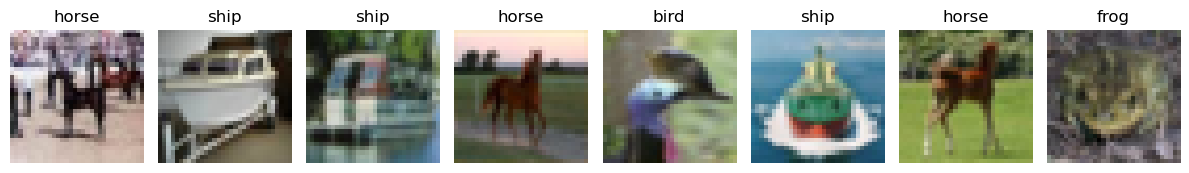

In [ ]:
def imshow(img, mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]):
    """Unnormalize and show an image tensor."""
    img = img.numpy().transpose((1, 2, 0))  # CHW -> HWC
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)

def show_samples(loader, classes, n=8):
    """Display a grid of n images from a DataLoader with their labels."""
    images, labels = next(iter(loader))
    plt.figure(figsize=(12, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        imshow(images[i])
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
show_samples(train_dl, cifar10_classes, n=8)

In [ ]:
image_size = train_dataset.__getitem__(0)[0].shape
patch_size = 4
embed_dim = 256
mlp_scale = 2
drop_rates = [0.0,0.0,0.0]
attn_heads = [4,8,8]
num_classes = len(cifar10_classes)
model = ViT(image_size,patch_size,embed_dim,num_classes=num_classes,attn_heads=attn_heads,mlp_scale=mlp_scale,drop_rates=drop_rates,device=device)
t_params = sum(p.numel() for p in model.parameters())
print("Network Parameters: ",t_params)
model.to(device)

Network Parameters:  1610858


ViT(
  (patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=48, out_features=256, bias=True)
    (3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (layers): ModuleList(
    (0-2): 3 x EncoderBlock(
      (LN1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MHSA(
        (k_proj): Linear(in_features=256, out_features=256, bias=False)
        (q_proj): Linear(in_features=256, out_features=256, bias=False)
        (v_proj): Linear(in_features=256, out_features=256, bias=False)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (c_proj): Linear(in_features=256, out_features=256, bias=False)
      (LN2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (FF): FF(
        (nn): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): GELU(approximate='none')

In [ ]:
torch.manual_seed(1)
num_epochs = 10
hist = train(model, num_epochs, train_dl, valid_dl,lr=1e-4)

In [ ]:
plot_loss(hist)

In [ ]:
total_acc, per_class_acc, cm = evaluate_model(model, test_dl, cifar10_classes, device)

In [ ]:
show_predictions(model,test_dataset,cifar10_classes,device)

### Bonus Question

Lets say we have our attn_heads list as [2,2,2] to start. If we instead change this to [8,8,8], what happens to our parameter count?
Why?